## TOKI Comment

- '03_FSI4135_NNwithC.V_algorithm.ipynb' で AI アルゴリズムが NN から Random Forest に変更になったもの。
- よって、'03_FSI4135_NNwithC.V_algorithm_aoki.ipynb' でのコメントが通用する
- df_train, df_trial の作成方法が'03_FSI4135_NNwithC.V_algorithm.ipynb'と異なり、間違いいではないが、何故そのような複雑な処理を取ったのか、理解できない。


- (English)
- In '03_FSI4135_NNwithC.V_algorithm.ipynb', the AI algorithm was changed from NN to Random Forest.
- Therefore, the comment in '03_FSI4135_NNwithC.V_algorithm_aoki.ipynb' is valid.
- The method of creating df_train and df_trial is different from '03_FSI4135_NNwithC.V_algorithm.ipynb', which is not a mistake, but I don't understand why such complicated processing was taken.  
 -> Nomura: Since it is time series data, it was extracted by period rather than random.

In [1]:
import os, math
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
print(tf.__version__)

# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
# change cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error ## MSE
from sklearn.metrics import r2_score ## R2
from sklearn.model_selection import KFold

In [5]:
#data_dir = '../../../MonitoringAI_CPW/DataForFSI4135'
data_dir = r'..\..\..\DataForFSI4135'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_num:",file_num)
print(data_filelist)

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    print(file_dir)
    df_tmp = pd.read_pickle(file_dir)
    df_raw = pd.concat([df_raw, df_tmp])
df_raw.reset_index(drop=True, inplace=True)
print("df_raw.shape:", df_raw.shape)

In [6]:
df_raw.shape

In [7]:
df = df_raw.copy()
df.reset_index(inplace=True, drop=True)
df.dropna(inplace=True)

In [8]:
df.head(5)

In [9]:
df.shape

### TOKI Comment
- training dataset を用意するのに多くの処理を行っている。train_test_split() で個数指定のランダム選出で済むはず。何故に多くの処理を経由する必要があるか？
    - df_train, df_trial = train_test_split(df, train_size=round(df.shape[0] * 0.9))


- English:
- A lot of processing is done to prepare the training dataset. Random selection by specifying the number with train_test_split () should be enough. Why do we need to go through so many processes?
     - df_train, df_trial = train_test_split (df, train_size = round (df.shape [0] * 0.9))
     -> Nomura: Since it is time series data, it was extracted by period rather than random.

In [10]:
#shuffle your dataframe in-place and reset the index
df = df.sample(frac=1).reset_index(drop=True)

In [11]:
df.head(5)

In [12]:
# explanatory variable - given
list_x = [
    'LC_4103.PV',
    'LC_4105.PV',
    'LC_4105.OP',
    'PC_4108.PV',
    'LC_4109.PV',
    'TI_4128.PV',
    'FI_4118.PV',
    'TI_4132.PV',
    'TI_4131.PV',
    'LC_4119.PV',
    'FI_4120.PV',
    'LC_4120.PV',
    'TI_4134.PV',
    'TI_4190.PV',
    'PC_4111.PV',
    'TI_4152.PV',
    'TI_4164.PV',
    'TI_4159.PV',
    'TI_4163.PV',
    'TI_4136.PV',
    'TC_4120.PV',
    'TI_4162.PV',
    'TI_4139.PV',
    'PC_4120.PV',
    'PC_4114.PV',
    'FC_4121.PV',
    'FC_4122.PV',
    'FC_4123.PV',
    'FC_4124.PV',
    'TC_4121.PV',
    'TI_4142.PV',
    'TI_4180.PV',
    'TC_4158.PV',
    'FC_4138.PV',
    'TI_4147.PV',
    'FC_4137.PV',
    'PC_4112.PV',
    'LC_4123.PV',
    'FC_4126.PV',
    'LC_4122.PV',
    'PI_4128.PV',
    'TI_4145.PV',
    'LC_4124.PV',
    'LC_4125.PV',
    'FC_4132.PV',
    'FSI4170.PV',
    'TI_4150.PV',
    'LC_4122.OP',
    'TI_4101.PV',
    'FI_4117.PV',
    'LC_4101.PV',
    'LC_4101.OP',
    'TI_4102.PV',
    'FSI4101.PV',
    'PC_4102.PV',
    'LIX41022.PV',
    'AI_41021.PV',
    'TI_4151.PV',
    'PQ_62003.PV',
    'PQ_62004.PV',
    'FC_61001.PV',
    'HC_4113.OP',
    'TI_4191.PV',
    'FSI4135.PV' #Target
]

# Target variable
list_y = [
    'FSI4135.PV' 
]

In [13]:
df_PAS_required_tags = df[list_x]

In [14]:
df_PAS_required_tags

## TOKI Comment

- processing : change "string" to "NaN" => remove "NaN" row

In [15]:
"""
for col in df_PAS_required_tags.columns[:]:
    df_PAS_required_tags[[col] = pd.to_numeric(df_PAS_required_tags[col], errors='coerce')
df_PAS_required_tags_dropna(inplace=True)
"""

In [16]:
# change "string" to "NaN"
df_PAS_required_removeString = []
for col in df_PAS_required_tags.columns[:]:
    remove_string = pd.to_numeric(df_PAS_required_tags[col], errors='coerce')
    df_PAS_required_removeString.append(remove_string)
    
pd.DataFrame(df_PAS_required_removeString).T

In [17]:
# remove "NaN" row
df_PAS_required_tags_dropna = pd.DataFrame(df_PAS_required_removeString).T.dropna(how="any", axis=0)
df_PAS_required_tags_dropna

In [18]:
a = df.shape[0] * 0.9
a = round(a)
print(a)

In [19]:
split_date = a
df_train = df_PAS_required_tags[: split_date]
df_train

In [20]:
df_trial = df_PAS_required_tags[split_date:]
df_trial

In [21]:
df_trial_X = df_trial.drop(columns=list_y)
df_trial_y = df_trial[list_y]

In [22]:
df_train_X = df_train.drop(columns=list_y)
df_train_y = df_train[list_y]

In [23]:
df_train_X.shape

## TOKI Comment
- "03_FSI4135_NNwithC.V_algorithm_atoki"に記載と同じコメント
- 関数の汎用化、モデル性能評価に、trial dataset も追加。
- モデル性能評価に　RMSE での比較も追加
- feature_importance の結果表示は必要か？
    - 表示するなら、1つのfigで4本のbarで表示し、比較できるようにした方がよいのでは？　下図のイメージ　
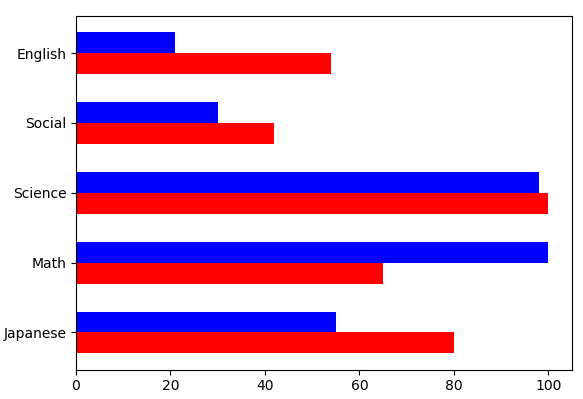
    - ほぼゼロが多いので、feature_importance<limitは表示しないようにするとか


- English:
- Same comment as described in "03_FSI4135_NNwithC.V_algorithm_atoki"
- Trial dataset has also been added to generalization of functions and model performance evaluation.
- Added RMSE comparison to model performance evaluation
- Is it necessary to display the result of feature_importance?
    - If you want to display it, it is better to display it with 4 bars in one fig so that you can compare it. Image of the figure below
! [image.png] (attachment: image.png)
     - Since there are many zeros, feature_importance < limit should not be displayed.

In [24]:
def cross_validate(data,label, tree_qty, depth, X_exp): #(train_X, train_y)

    skf = KFold(n_splits=5,random_state=1, shuffle = True)

    models = []
    train_scores = []
    validation_scores = []

    for train_index, val_index in skf.split(data,label): # Split train data
    
        train_data=data[train_index]       
        train_label=label[train_index]       
        val_data=data[val_index]
        val_label=label[val_index]
        
        rgr=RandomForestRegressor(n_estimators=tree_qty, max_depth=depth, random_state=1)
        
        from pprint import pprint
        # Look at parameters used by our current forest
        print('Parameters currently in use:\n')
        pprint(rgr.get_params())
  
        rgr.fit(train_data, train_label) # develop prediction model
        models.append(rgr)
        
        train_score = rgr.score(train_data, train_label)
        train_scores.append(train_score)
        
        validation_score= rgr.score(val_data, val_label)  
        validation_scores.append(validation_score)
        
        # Feature Importance
        fti = rgr.feature_importances_

        # save Feature Importance
        ImporTable=pd.concat([pd.DataFrame(X_exp.T.index),pd.DataFrame(fti)],axis=1)
        ImporTable.to_csv('02_importance.csv')

        # edit Feature Importance
        ImporTable.columns = [0,1]
        ImporTable_ = ImporTable.set_index(0)
        ImporTable_ = ImporTable_.sort_values(1,ascending=True)

        ImporTable_Y = ImporTable_.iloc[:,0][-63:]
        ImporTable_X = np.arange(len(ImporTable_Y))

        plt.figure(figsize=(10, 25))

        label_ = ImporTable_Y.index
        
        # visualize Feature Importance
        plt.title(
                  "train_score = "+("{:.4f}".format(train_score))+"\n"
                  "validation_score = "+("{:.4f}".format(validation_score))+"\n"
                  "feature_importance")
        plt.barh(ImporTable_X, ImporTable_Y, align="center",tick_label=label_, linewidth=0.1)   # bar chart
        plt.yticks(ImporTable_X, ImporTable_.index)  # x-axis label
        plt.grid()
        plt.show()
        
    # visualize "train_score VS validation_score"
    fig, ax1 = plt.subplots(figsize=(3, 3))
    x = list(range(len(models)))

    ax1.plot(x, train_scores,"-",label="train_scores", lw=1, marker='o', markersize=2, markeredgewidth=4) ## 系列１をプロット
    ax1.plot(x, validation_scores,"-",label="validation_scores", alpha=0.8, lw=1, marker='o', markersize=2, markeredgewidth=4) # 系列２をプロット
    ax1.set_title('train_score vs validation_score')
    ax1.set_xlabel('model ID')
    ax1.set_ylabel('score')
    ax1.legend(loc='lower left', bbox_to_anchor=(1, 0))
    ax1.grid()

    plt.show()
  
    return models

In [25]:
models = cross_validate(df_train_X.values, df_train_y.values, 10, 100, df_train_X)

In [26]:
# output ensemble mean value from rach models developed by cross-validation
def def_pred_ensemble(model, df_trial):
    sum_predictedValue = 0
    for i in range(len(model)):
        sum_predictedValue = sum_predictedValue + model[i].predict(df_trial)

    pred_ensemble = sum_predictedValue/len(model)
    return pred_ensemble

In [27]:
pred_ensemble = def_pred_ensemble(models, df_trial_X)
pred_ensemble

In [28]:
from sklearn.metrics import r2_score

# output R2 score of rach models developed by cross-validation
def def_score_ensemble(model, df_trial_X, df_trial_y):
    for i in range(len(model)):
        print("model_"+ '{}'.format(i) +" "+ "score:", "{:.3f}".format(model[i].score(df_trial_X,df_trial_y)))
    
    score_predictedEnsemble = r2_score(def_pred_ensemble(models, df_trial_X),df_trial_y)
    print('ensemble score: {:.3f}'.format(score_predictedEnsemble))
    return score_predictedEnsemble

In [29]:
print("R2 Score for Trial Dataset")
score_predictedEnsemble = def_score_ensemble(models, df_trial_X, df_trial_y)

In [30]:
x = df_trial_X.index

In [31]:
#fig, ax1 = plt.subplots(figsize=(500, 5))
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

ax1.plot(x, df_trial_y.values.reshape(-1,1),"-",label="Measured", lw=1, marker='o', markersize=2, markeredgewidth=4)
ax1.plot(x, pred_ensemble,"-",label="Predicted", alpha=0.8, lw=1, marker='o', markersize=2, markeredgewidth=4)
ax2.plot(x, df_trial_y.values.reshape(-1,1) - pred_ensemble.reshape(-1,1),"-r",label="Error", alpha=0.5, lw=1, marker='o', markersize=0.5, markeredgewidth=4)

ax1.set_title('XCV-18573A Measured vs Predicted')
ax1.set_xlabel('Date')
ax1.set_ylabel('XCV-18573A')
ax2.set_ylabel('Error')
ax1.grid()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="best")

print("trial_score:{:.3f}".format(score_predictedEnsemble))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(df_trial_y, pred_ensemble)))